In [147]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [153]:
import sys
sys.path.append('C:\\Users\\Nachiket\\Documents\\Python-useful_packages\\Boruta-0.1.5')

In [155]:
from boruta import boruta_py

### Import the data

In [156]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("clean_data_basic_pdayscat_agecat.csv",index_col=False)

In [ ]:
df.head()

In [97]:
print ( "{}% of the contacts were successful".format(round(len(df.loc[df.y == 1])*100.0/len(df),2)))

11.26% of the contacts were successful


In [157]:
#Dropping one column each from categorical variables to avoid redunduncy
# df = df.drop([
#  'poutcome_success',
#  'job_unemployed',
#  'marital_divorced',
#  'month_apr',
#  'day_of_week_fri'],axis=1)
# df = df.drop([])
# df = df.drop('Unnamed: 0',axis=1)
features = df.drop('y',axis=1)

### Split the data into training and test sets for final testing

In [158]:
X, Xtest, y, ytest = train_test_split(features, df['y'],random_state=5,test_size=0.3)

In [159]:
print(df.shape)
print (X.shape)

(40787, 51)
(28550, 50)


In [160]:
len(df.loc[ytest.index,:].loc[df.y == 1]) # Overall Positives

1344

## Normalization

In [161]:
def normalizer(traindata,testdata):
    
    trainnormalized = (traindata-min(traindata))/(max(traindata)-min(traindata))
    testnormalized = (testdata-min(traindata))/(max(traindata)-min(traindata))
    return trainnormalized, testnormalized


for column in X:
    X[column], Xtest[column] = normalizer(X[column],Xtest[column])

Xtest.head(2)
# df.education = normalizer(df.education)

C:\Users\Nachiket\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,age,education,default,housing,loan,contact,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pdayscat,poutcome_failure,poutcome_nonexistent,poutcome_success,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,agecat_adult,agecat_senior,agecat_young
22058,0.382716,0.833333,0.0,1.0,0.0,0.0,0.024390,1.0,0.000000,0.333333,0.269680,0.192469,0.158694,0.512287,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
18678,0.296296,1.000000,0.0,0.0,0.0,1.0,0.073171,1.0,0.142857,0.687500,0.389322,0.368201,0.780322,0.877883,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [174]:
if 1==0:
    # L1 Based feature selection
    from sklearn.feature_selection import SelectFromModel
    from sklearn.svm import LinearSVC

    print ("\t\tBefore")
    print (" X - {}".format(X.shape))
    print (" Xtest - {}".format(Xtest.shape))

    lsvc = LinearSVC(C=0.01, penalty="l2", dual=False).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    X = model.transform(X)
    Xtest = model.transform(Xtest)

    print ("\t\tBefore")
    print (" X - {}".format(X.shape))
    print (" Xtest - {}".format(Xtest.shape))

In [173]:
if 1 == 0:
    # Boruta

    # define random forest classifier, with utilising all cores and
    # sampling in proportion to y labels
    forest = RandomForestClassifier(n_jobs=-1, class_weight='auto')

    # define Boruta feature selection method
    feat_selector = boruta_py.BorutaPy(forest, n_estimators='auto', verbose=2)

    # find all relevant features
    feat_selector.fit(X.values, y.values)

    # check selected features
    feat_selector.support_

    # check ranking of features
    feat_selector.ranking_
    
    # call transform() on X to filter it down to selected features
    X_filtered = feat_selector.transform(X.values)
    X_test = feat_selector.transform(Xtest.values)

### Tuning

In [107]:
def cv_score(clf, x, y, score_func=f1_score): #Apply k-fold cross velidation
    result = 0
    nfold = 5
    for train, test in KFold(nfold,random_state=0).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(y[test],clf.predict(x[test])) # evaluate score function on held-out data
    return result / nfold # average

In [12]:
y.shape

(28550,)

In [172]:
clf = LogisticRegression(random_state=0)
score = cv_score(clf, X_filtered, y.values)
print(score)

0.127952362596


#### Tune C

In [145]:
#the grid of parameters to search over
Cs = [0.001,0.01, 0.1, 1, 10, 100,200, 500]
# Cs = [100, 150, 200, 300]
max_score = 0
# your turn
for C in Cs:
    clf = LogisticRegression(C=C,random_state=1)
    score = cv_score(clf, X.values, y.values)
#     print (score)
    if score > max_score:
        max_score = score
        Cfinal = C
print ("Maximum score of {} is achieved at C = {}".format(max_score,Cfinal))

Maximum score of 0.3498213128161022 is achieved at C = 100


In [146]:
# your turn
clf = LogisticRegression(C=Cfinal,random_state=1)
clf.fit(X.values, y.values)
print(f1_score(ytest, clf.predict(Xtest)))
#clf.score(Xtestlr,ytestlr)

0.344565217391


* **Attempt 1 : Basic Clean Data                : 0.901201274822**
* **Attempt 2 : Basic Clean Data + Categorical age and pdays              : 0.901201274822**
* **Attempt 3 : Basic Clean Data + Normalization : 0.902263626706**
* **Attempt 4 : Basic Clean Data + Normalization + Categorical age and pdays: 0.902263626706**

In [135]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, clf.predict(Xtest))
cm

array([[10714,   179],
       [ 1027,   317]])

In this problem it might make sence to optimize towards maximizing towards accurate prediction of people who will subscribe to the service.
In this case we accurately predicted 317 people out of 179. So, let's try making that a scoring criteria.
** In our context - that is True Positives / Actual Positives, i.e. True Positive Rate / Recall / Sensitivity

In [90]:
from sklearn.metrics import recall_score
recall = recall_score(ytest,clf.predict(Xtest))
recall

0.23586309523809523

## SVC

In [91]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV

In [92]:
#Initial Run
svc = SVC()
score = cv_score(svc, X.values, y.values)
print(score)

svc = LinearSVC()
score = cv_score(svc, X.values, y.values)
print(score)

0.32151363099
0.327350545056


In [ ]:
#Tuning Using GridSearchCV

parameters = {'kernel':('linear', 'rbf'),'C':[1,5,10],  'gamma': 
              [0.01,0.10,0.5]}
# 
svr = SVC()
grid = GridSearchCV(svr, parameters, scoring='recall')
grid.fit(X.values, y.values)
predicted = grid.predict(Xtest)

In [ ]:
score = grid.score(Xtest.values)
print(score)
print(accuracy_score(predicted, ytest))
cnf_matrix = confusion_matrix(ytest, predicted)
print(cnf_matrix)

In [ ]:
grid.best_estimator_
# SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#   decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
#   max_iter=-1, probability=False, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)

In [ ]:
# your turn
svcfinal = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
svcfinal.fit(X, y)

In [ ]:
print(accuracy_score(svcfinal.predict(Xtest), ytest))
#clf.score(Xtestlr,ytestlr)

## Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier

In [99]:
#Initial Run
rf = RandomForestClassifier(n_estimators=50)
score = cv_score(rf, X.values, y.values)
print(score)

0.364153516257


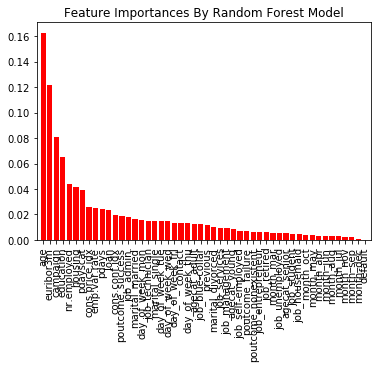

In [121]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

predictors = list(features.columns)

importances=rf.feature_importances_

indices = np.argsort(importances)[::-1]

sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
    
plt.figure()
plt.title("Feature Importances By Random Forest Model")
plt.bar(range(np.size(predictors)), importances[indices],
       color="r")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)]);

In [139]:
features=features[sorted_important_features[:-2]]
sorted_important_features[-5:]

['month_jul', 'month_nov', 'month_sep', 'month_dec', 'default']

In [ ]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

parameters = {'n_estimators':[20,30,50,100],''}

gs = GridSearchCV(rf,parameters)
gs.fit(X,y)